In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from pandas import DataFrame
from pandas import concat
from math import sqrt
#plt.style.use('fivethirtyeight')
#plt.style.use('classic')
#plt.style.use('ggplot')

In [3]:
# Función para transformar datos crudos en datos para el aprendizaje de una serie de tiempo
def desfasar(data, n_atras=1, n_adelante=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dfd = DataFrame(data)
    cols, names = list(), list()
    aux=dfd.columns.values
    # Secuencia de entrada (t-n, ... t-1)
    for i in range(n_atras, 0, -1):
        cols.append(dfd.shift(i))
        names += [f'{aux[j]}(t-{i})' for j in range(n_vars)]
    # Secuencia de pronostico (t, t+1, ... t+n)
    for i in range(0, n_adelante+1):
        cols.append(dfd.shift(-i))
        if i == 0:
            names += [f'{aux[j]}(t)' for j in range(n_vars)]
        else:
            names += [f'{aux[j]}(t+{i})' for j in range(n_vars)]
    # Juntar toda la informacion
    agg = concat(cols, axis=1)
    agg.columns = names
    # Eliminar los registros con valores NaN
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [4]:
# #Lectura de datos
# FILE = 'DATOS_SEMANALES/DATOS_SEMANALES_ESTACIONES_NINO_INTERPOLADOS.csv'
# df = pd.read_csv(FILE, index_col=0, parse_dates=True)

# df = df.dropna()

# df = df.replace(np.inf, np.nan).replace(-np.inf, np.nan).dropna()

# exog_x=df[['PTPM_CON', 'TA2_AUT_60_MEAN', 'TA2_AUT_60_AMIN', 'TA2_AUT_60_AMAX', 'HRA2_AUT_60_MEAN', 'HRA2_AUT_60_AMIN', 'NINO3', 'ANOM.1', 'NINO4', 'ANOM.2', 'NINO3.4', 'ANOM.3', 'ONI_ASCII', 'MEI']]
# endog_y_c=df['CONFIRMED_CASES']
# endog_y_a=df['ALL_CASES']

# exog_x_Train = exog_x[0:445]
# exog_x_Test = exog_x[445:607]
# exog_x_pron = exog_x[607:]
# endog_y_Train_c = endog_y_c[0:445]
# endog_y_Test_c = endog_y_c[445:607]
# endog_y_pron_c = endog_y_c[607:]
# endog_y_Train_a = endog_y_a[0:445]
# endog_y_Test_a = endog_y_a[445:607]
# endog_y_pron_a = endog_y_a[607:]

# # print(endog_y_Train_c)
# # print(endog_y_Test_c)
# # print(endog_y_c)


In [5]:
def evalua_modelo(FILE, n_desfase, Limite_I, Limite_S, C, N):
    import pandas as pd
    df = pd.read_csv(FILE)
    df = df.dropna()

    df
    
    if C == 'Todos':
        Columna = 'ALL_CASES'
        Mensaje = 'Todos los casos'
    else:
        Columna = 'CONFIRMED_CASES'
        Mensaje = 'Casos confirmados'

    exog_x1 = df[['PTPM_CON', 'TA2_AUT_60_MEAN', 'TA2_AUT_60_AMAX', 'HRA2_AUT_60_MEAN', 'HRA2_AUT_60_AMAX', 'NINO3', 'NINO4', 'NINO3.4','CONFIRMED_CASES', 'ALL_CASES']]
    
    
    aic = []
    MSE = []
    MAE = []
    pp = []
    pd = []
    pq = []
    dsf = []
    arma_params = [] 

    for desfase in range (0, n_desfase):
        exog_x = desfasar(exog_x1, 0, desfase);
        print(exog_x)
        endog_y = df[Columna].shift(-desfase).dropna();
        exog_x_Train = exog_x[0:Limite_I];
        exog_x_Test = exog_x[Limite_I:Limite_S];
        exog_x_Pron = exog_x[Limite_S:];
        endog_y_Train = endog_y[0:Limite_I];
        endog_y_Test = endog_y[Limite_I:Limite_S];
        endog_y_Pron = endog_y[Limite_S:];


        for p in range(N):
            for d in range(N):
                for q in range(N):
                    try:
                        # Ajuste del modelo  -  ARMA Casos Confirmados
                        model = ARIMA(endog_y_Train, order=(p, d, q), exog=exog_x_Train);
                        model_fit = model.fit(disp=False);
                        #Predicción para el conjunto de test
                        yhat = model_fit.predict(len(endog_y_Train), len(endog_y_Train)+len(endog_y_Test)-1, exog=exog_x_Test);
                        mse = mean_squared_error(endog_y_Test.values, yhat.values);
                        mae = mean_absolute_error(endog_y_Test.values, yhat.values);
                        pp.append(p)
                        pd.append(d)
                        pq.append(q)
                        dsf.append(desfase)
                        aic.append(model_fit.aic);
                        arma_params.append('ARMA P = {} x D = {} x Q = {}, Desfase = {}, AIC = {}, MSE = {}, MAE = {}'.format(p, d, q, desfase, model_fit.aic, mse, mae));        
                        MSE.append(mse);
                        MAE.append(mae);
                    except:

                        continue

    # Extracción de valores minimos del modelo

    #Grafico de ajuste del modelo
    plt.title(r'Criterio de información de Akaike (AIC)')
    plt.xlabel('Numero de prueba')
    plt.ylabel('Valor (AIC)')
    plt.plot(aic)
    plt.show()
    print('\n\n\n')
    plt.title(r'Error cuadratico medio (MSE)')
    plt.xlabel('Numero de prueba')
    plt.ylabel('Valor (MSE)')
    plt.plot(MSE)
    plt.show()
    print('\n\n\n')
    plt.title(r'Error absoluto medio (MAE)')
    plt.xlabel('Numero de prueba')
    plt.ylabel('Valor (MAE)')
    plt.plot(MAE)
    plt.show()
    
    
    
    
    
    
    #Minimo por AIC
    indice = aic.index(np.array(aic).min())
    p = pp[indice]
    d = pd[indice]
    q = pq[indice]
    desfase = dsf[indice]
    desfase = 15
    print('Minimo del Criterio Akaike: ',np.array(aic).min())
    print('Parametros: P= ', p , 'D = ' , d, 'Q = ' , q , 'Desfase = ' , desfase)

    exog_x = desfasar(exog_x1, 0, desfase);
    endog_y=df[Columna].shift(-desfase).dropna();
    exog_x_Train = exog_x[0:Limite_I];
    exog_x_Test = exog_x[Limite_I:Limite_S];
    exog_x_Pron = exog_x[Limite_S:];
    endog_y_Train = endog_y[0:Limite_I];
    endog_y_Test = endog_y[Limite_I:Limite_S];
    endog_y_Pron = endog_y[Limite_S:];


    
    model = ARIMA(endog_y_Train, order=(p, d, q), exog=exog_x_Train);
    model_fit = model.fit(disp=False);
    #Predicción para el conjunto de test
#     print(len(endog_y_Train))
#     print(len(endog_y_Train)+len(endog_y_Test)-1)
#     print(len(exog_x_Test)) 
#     print(exog_x_Test)
#     print('\n\n\n')
    yhat = model_fit.predict(len(endog_y_Train), len(endog_y_Train)+len(endog_y_Test)-1, exog=exog_x_Test);
    #Prediccion para el conjunto de pronostico
#     print(len(endog_y_Train)+len(endog_y_Test))
#     print(len(endog_y_Train)+len(endog_y_Test)+len(endog_y_Pron)-1)
#     print(len(exog_x_Pron))
#     print(exog_x_Pron)
#     print('\n\n\n')
    
    
    
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++    
    
    yhat_p = model_fit.predict(len(endog_y_Train), len(endog_y_Train)+len(endog_y_Pron)-1, exog=exog_x_Pron);
    
    
    y_l = []
    y_l.append(endog_y_Pron)
    y_l.append(yhat_p)
    print('************************* y_l *******************')
    print(y_l)

    # Trazar el grafico de TEST
    plt.figure(figsize=(10, 8));
    plt.title(r'TEST - Conjunto de evaluación - '+Mensaje)
    plt.plot(yhat.values,color="#0000ff", ls="--", lw="4",label='Pronostico');
    plt.plot(endog_y_Test.values,color="green", ls="-.", lw="4",label='Casos reales');
    plt.xlabel('Fecha')
    plt.ylabel('Número de casos')
    plt.grid=True
    plt.legend()

    plt.show()
    
    # Trazar el grafico de PRONOSTICO
    plt.figure(figsize=(10, 8));
    plt.title(r'PRONOSTICO - Conjunto de evaluación - '+Mensaje)
    plt.plot(yhat_p.values,color="#0000ff", ls="--", lw="4",label='Pronostico');
    plt.plot(endog_y_Pron.values,color="green", ls="-.", lw="4",label='Casos reales');
    plt.xlabel('Fecha')
    plt.ylabel('Número de casos')
    plt.grid=True
    plt.legend()

    plt.show()
    
    
    #Minimo por MSE
    indice = MSE.index(np.array(MSE).min())
    p = pp[indice]
    d = pd[indice]
    q = pq[indice]
    desfase = dsf[indice]
    print('Minimo Error Cuadratico Medio: ',np.array(MSE).min())
    print('Parametros: P= ',p, 'D = ' , d,'Q = ',q,'Desfase = ',desfase)

    exog_x = desfasar(exog_x1, 0, desfase);
    endog_y=df[Columna].shift(-desfase).dropna();
    exog_x_Train = exog_x[0:Limite_I];
    exog_x_Test = exog_x[Limite_I:Limite_S];
    exog_x_Pron = exog_x[Limite_S:];
    endog_y_Train = endog_y[0:Limite_I];
    endog_y_Test = endog_y[Limite_I:Limite_S];
    endog_y_Pron = endog_y[Limite_S:];    
    
    
    
    
    model = ARIMA(endog_y_Train, order=(p, d, q), exog=exog_x_Train);
    model_fit = model.fit(disp=False);
    #Predicción para el conjunto de test
    yhat = model_fit.predict(len(endog_y_Train), len(endog_y_Train)+len(endog_y_Test)-1, exog=exog_x_Test);
    #Prediccion para el conjunto de pronostico
    yhat_p = model_fit.predict(len(endog_y_Train), len(endog_y_Train)+len(endog_y_Pron)-1, exog=exog_x_Pron);
    # Trazar el grafico de TEST
    plt.figure(figsize=(10, 8));
    plt.title(r'TEST - Conjunto de evaluación - '+Mensaje)
    plt.plot(yhat.values,color="#0000ff", ls="--", lw="4",label='Pronostico');
    plt.plot(endog_y_Test.values,color="green", ls="-.", lw="4",label='Casos reales');
    plt.xlabel('Fecha')
    plt.ylabel('Número de casos')
    plt.grid=True
    plt.legend()

    plt.show()
    
    # Trazar el grafico de PRONOSTICO
    plt.figure(figsize=(10, 8));
    plt.title(r'PRONOSTICO - Conjunto de evaluación - '+Mensaje)
    plt.plot(yhat_p.values,color="#0000ff", ls="--", lw="4",label='Pronostico');
    plt.plot(endog_y_Pron.values,color="green", ls="-.", lw="4",label='Casos reales');
    plt.xlabel('Fecha')
    plt.ylabel('Número de casos')
    plt.grid=True
    plt.legend()

    plt.show()
    

    
    #Minimo por MAE    
    indice = MAE.index(np.array(MAE).min())
    p = pp[indice]
    d = pd[indice]
    q = pq[indice]
    desfase = dsf[indice]
    desfase = 15
    print('Minimo Error Absoluto: ',np.array(MAE).min())
    print('Parametros: P= ',p, 'D = ' , d,'Q = ',q,'Desfase = ',desfase)

    exog_x = desfasar(exog_x1, 0, desfase);
    endog_y=df[Columna].shift(-desfase).dropna();
    exog_x_Train = exog_x[0:Limite_I];
    exog_x_Test = exog_x[Limite_I:Limite_S];
    exog_x_Pron = exog_x[Limite_S:];
    endog_y_Train = endog_y[0:Limite_I];
    endog_y_Test = endog_y[Limite_I:Limite_S];
    endog_y_Pron = endog_y[Limite_S:];    
    
    
    
    
    model = ARIMA(endog_y_Train, order=(p, d, q), exog=exog_x_Train);
    model_fit = model.fit(disp=False);
    #Predicción para el conjunto de test
    yhat = model_fit.predict(len(endog_y_Train), len(endog_y_Train)+len(endog_y_Test)-1, exog=exog_x_Test);
    #Prediccion para el conjunto de pronostico
    yhat_p = model_fit.predict(len(endog_y_Train), len(endog_y_Train)+len(endog_y_Pron)-1, exog=exog_x_Pron);

    # Trazar el grafico de TEST
    plt.figure(figsize=(10, 8));
    plt.title(r'TEST - Conjunto de evaluación - '+Mensaje)
    plt.plot(yhat.values,color="#0000ff", ls="--", lw="4",label='Pronostico');
    plt.plot(endog_y_Test.values,color="green", ls="-.", lw="4",label='Casos reales');
    plt.xlabel('Fecha')
    plt.ylabel('Número de casos')
    plt.grid=True
    plt.legend()

    plt.show()

    
    # Trazar el grafico de PRONOSTICO
    plt.figure(figsize=(10, 8));
    plt.title(r'PRONOSTICO - Conjunto de evaluación - '+Mensaje)
    plt.plot(yhat_p.values,color="#0000ff", ls="--", lw="4",label='Pronostico');
    plt.plot(endog_y_Pron.values,color="green", ls="-.", lw="4",label='Casos reales');
    plt.xlabel('Fecha')
    plt.ylabel('Número de casos')
    plt.grid=True
    plt.legend()

    plt.show()
    
    
    print('\n\nParametros de Criterio Akaike minimo: ',aic.index(np.array(aic).min()),arma_params[aic.index(np.array(aic).min())])
    print('\nParametros de RMSE minimo: ',MSE.index(np.array(MSE).min()),arma_params[MSE.index(np.array(MSE).min())])
    print('\nParametros de RMSE minimo: ',MAE.index(np.array(MAE).min()),arma_params[MAE.index(np.array(MAE).min())])
    print('\n\n\n')
    
    df




In [6]:
#Datos mensuales no estandarizados

     PTPM_CON(t)  TA2_AUT_60_MEAN(t)  TA2_AUT_60_AMAX(t)  HRA2_AUT_60_MEAN(t)  \
0           27.2           24.994293                31.1            72.210598   
1           11.2           24.803634                31.4            72.344979   
2           26.1           23.802560                30.7            81.267857   
3           47.4           24.527267                31.1            74.266129   
4           39.0           24.237500                31.1            76.517857   
..           ...                 ...                 ...                  ...   
632          1.6           26.129762                34.5            66.011905   
633         21.9           23.673810                30.5            74.708333   
634         11.8           25.099405                32.8            71.714286   
635          0.0           26.537500                33.6            67.488095   
636          2.0           25.169792                31.8            72.489583   

     HRA2_AUT_60_AMAX(t)   

D:\ProgramData\Anaconda3\envs\tf2\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
D:\ProgramData\Anaconda3\envs\tf2\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\ProgramData\Anaconda3\envs\tf2\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
D:\ProgramData\Anaconda3\envs\tf2\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


     PTPM_CON(t)  TA2_AUT_60_MEAN(t)  TA2_AUT_60_AMAX(t)  HRA2_AUT_60_MEAN(t)  \
0           27.2           24.994293                31.1            72.210598   
1           11.2           24.803634                31.4            72.344979   
2           26.1           23.802560                30.7            81.267857   
3           47.4           24.527267                31.1            74.266129   
4           39.0           24.237500                31.1            76.517857   
..           ...                 ...                 ...                  ...   
630          0.0           24.952976                31.6            71.220238   
631          0.0           25.517857                32.8            69.613095   
632          1.6           26.129762                34.5            66.011905   
633         21.9           23.673810                30.5            74.708333   
634         11.8           25.099405                32.8            71.714286   

     HRA2_AUT_60_AMAX(t)   

D:\ProgramData\Anaconda3\envs\tf2\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
D:\ProgramData\Anaconda3\envs\tf2\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


     PTPM_CON(t)  TA2_AUT_60_MEAN(t)  TA2_AUT_60_AMAX(t)  HRA2_AUT_60_MEAN(t)  \
0           27.2           24.994293                31.1            72.210598   
1           11.2           24.803634                31.4            72.344979   
2           26.1           23.802560                30.7            81.267857   
3           47.4           24.527267                31.1            74.266129   
4           39.0           24.237500                31.1            76.517857   
..           ...                 ...                 ...                  ...   
629          2.2           24.811310                31.2            74.577381   
630          0.0           24.952976                31.6            71.220238   
631          0.0           25.517857                32.8            69.613095   
632          1.6           26.129762                34.5            66.011905   
633         21.9           23.673810                30.5            74.708333   

     HRA2_AUT_60_AMAX(t)   

D:\ProgramData\Anaconda3\envs\tf2\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
D:\ProgramData\Anaconda3\envs\tf2\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


     PTPM_CON(t)  TA2_AUT_60_MEAN(t)  TA2_AUT_60_AMAX(t)  HRA2_AUT_60_MEAN(t)  \
0           27.2           24.994293                31.1            72.210598   
1           11.2           24.803634                31.4            72.344979   
2           26.1           23.802560                30.7            81.267857   
3           47.4           24.527267                31.1            74.266129   
4           39.0           24.237500                31.1            76.517857   
..           ...                 ...                 ...                  ...   
628         28.7           24.308929                31.1            73.553571   
629          2.2           24.811310                31.2            74.577381   
630          0.0           24.952976                31.6            71.220238   
631          0.0           25.517857                32.8            69.613095   
632          1.6           26.129762                34.5            66.011905   

     HRA2_AUT_60_AMAX(t)   

D:\ProgramData\Anaconda3\envs\tf2\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
D:\ProgramData\Anaconda3\envs\tf2\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


     PTPM_CON(t)  TA2_AUT_60_MEAN(t)  TA2_AUT_60_AMAX(t)  HRA2_AUT_60_MEAN(t)  \
0           27.2           24.994293                31.1            72.210598   
1           11.2           24.803634                31.4            72.344979   
2           26.1           23.802560                30.7            81.267857   
3           47.4           24.527267                31.1            74.266129   
4           39.0           24.237500                31.1            76.517857   
..           ...                 ...                 ...                  ...   
627         49.2           23.288095                29.6            81.071429   
628         28.7           24.308929                31.1            73.553571   
629          2.2           24.811310                31.2            74.577381   
630          0.0           24.952976                31.6            71.220238   
631          0.0           25.517857                32.8            69.613095   

     HRA2_AUT_60_AMAX(t)   

D:\ProgramData\Anaconda3\envs\tf2\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
D:\ProgramData\Anaconda3\envs\tf2\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


     PTPM_CON(t)  TA2_AUT_60_MEAN(t)  TA2_AUT_60_AMAX(t)  HRA2_AUT_60_MEAN(t)  \
0           27.2           24.994293                31.1            72.210598   
1           11.2           24.803634                31.4            72.344979   
2           26.1           23.802560                30.7            81.267857   
3           47.4           24.527267                31.1            74.266129   
4           39.0           24.237500                31.1            76.517857   
..           ...                 ...                 ...                  ...   
626         30.6           24.519643                31.7            76.946429   
627         49.2           23.288095                29.6            81.071429   
628         28.7           24.308929                31.1            73.553571   
629          2.2           24.811310                31.2            74.577381   
630          0.0           24.952976                31.6            71.220238   

     HRA2_AUT_60_AMAX(t)   

D:\ProgramData\Anaconda3\envs\tf2\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
D:\ProgramData\Anaconda3\envs\tf2\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


     PTPM_CON(t)  TA2_AUT_60_MEAN(t)  TA2_AUT_60_AMAX(t)  HRA2_AUT_60_MEAN(t)  \
0           27.2           24.994293                31.1            72.210598   
1           11.2           24.803634                31.4            72.344979   
2           26.1           23.802560                30.7            81.267857   
3           47.4           24.527267                31.1            74.266129   
4           39.0           24.237500                31.1            76.517857   
..           ...                 ...                 ...                  ...   
625         23.6           24.591667                30.7            76.767857   
626         30.6           24.519643                31.7            76.946429   
627         49.2           23.288095                29.6            81.071429   
628         28.7           24.308929                31.1            73.553571   
629          2.2           24.811310                31.2            74.577381   

     HRA2_AUT_60_AMAX(t)   

D:\ProgramData\Anaconda3\envs\tf2\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
D:\ProgramData\Anaconda3\envs\tf2\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


     PTPM_CON(t)  TA2_AUT_60_MEAN(t)  TA2_AUT_60_AMAX(t)  HRA2_AUT_60_MEAN(t)  \
0           27.2           24.994293                31.1            72.210598   
1           11.2           24.803634                31.4            72.344979   
2           26.1           23.802560                30.7            81.267857   
3           47.4           24.527267                31.1            74.266129   
4           39.0           24.237500                31.1            76.517857   
..           ...                 ...                 ...                  ...   
624         13.5           24.045833                30.5            78.458333   
625         23.6           24.591667                30.7            76.767857   
626         30.6           24.519643                31.7            76.946429   
627         49.2           23.288095                29.6            81.071429   
628         28.7           24.308929                31.1            73.553571   

     HRA2_AUT_60_AMAX(t)   

D:\ProgramData\Anaconda3\envs\tf2\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
D:\ProgramData\Anaconda3\envs\tf2\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


     PTPM_CON(t)  TA2_AUT_60_MEAN(t)  TA2_AUT_60_AMAX(t)  HRA2_AUT_60_MEAN(t)  \
0           27.2           24.994293                31.1            72.210598   
1           11.2           24.803634                31.4            72.344979   
2           26.1           23.802560                30.7            81.267857   
3           47.4           24.527267                31.1            74.266129   
4           39.0           24.237500                31.1            76.517857   
..           ...                 ...                 ...                  ...   
623         67.1           23.852976                32.0            79.279762   
624         13.5           24.045833                30.5            78.458333   
625         23.6           24.591667                30.7            76.767857   
626         30.6           24.519643                31.7            76.946429   
627         49.2           23.288095                29.6            81.071429   

     HRA2_AUT_60_AMAX(t)   

D:\ProgramData\Anaconda3\envs\tf2\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
D:\ProgramData\Anaconda3\envs\tf2\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


     PTPM_CON(t)  TA2_AUT_60_MEAN(t)  TA2_AUT_60_AMAX(t)  HRA2_AUT_60_MEAN(t)  \
0           27.2           24.994293                31.1            72.210598   
1           11.2           24.803634                31.4            72.344979   
2           26.1           23.802560                30.7            81.267857   
3           47.4           24.527267                31.1            74.266129   
4           39.0           24.237500                31.1            76.517857   
..           ...                 ...                 ...                  ...   
622         24.7           24.604762                31.1            73.529762   
623         67.1           23.852976                32.0            79.279762   
624         13.5           24.045833                30.5            78.458333   
625         23.6           24.591667                30.7            76.767857   
626         30.6           24.519643                31.7            76.946429   

     HRA2_AUT_60_AMAX(t)   

D:\ProgramData\Anaconda3\envs\tf2\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
D:\ProgramData\Anaconda3\envs\tf2\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


     PTPM_CON(t)  TA2_AUT_60_MEAN(t)  TA2_AUT_60_AMAX(t)  HRA2_AUT_60_MEAN(t)  \
0           27.2           24.994293                31.1            72.210598   
1           11.2           24.803634                31.4            72.344979   
2           26.1           23.802560                30.7            81.267857   
3           47.4           24.527267                31.1            74.266129   
4           39.0           24.237500                31.1            76.517857   
..           ...                 ...                 ...                  ...   
621          9.9           24.651786                30.8            71.494048   
622         24.7           24.604762                31.1            73.529762   
623         67.1           23.852976                32.0            79.279762   
624         13.5           24.045833                30.5            78.458333   
625         23.6           24.591667                30.7            76.767857   

     HRA2_AUT_60_AMAX(t)   

D:\ProgramData\Anaconda3\envs\tf2\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
D:\ProgramData\Anaconda3\envs\tf2\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


     PTPM_CON(t)  TA2_AUT_60_MEAN(t)  TA2_AUT_60_AMAX(t)  HRA2_AUT_60_MEAN(t)  \
0           27.2           24.994293                31.1            72.210598   
1           11.2           24.803634                31.4            72.344979   
2           26.1           23.802560                30.7            81.267857   
3           47.4           24.527267                31.1            74.266129   
4           39.0           24.237500                31.1            76.517857   
..           ...                 ...                 ...                  ...   
620         12.9           23.400595                30.9            74.470238   
621          9.9           24.651786                30.8            71.494048   
622         24.7           24.604762                31.1            73.529762   
623         67.1           23.852976                32.0            79.279762   
624         13.5           24.045833                30.5            78.458333   

     HRA2_AUT_60_AMAX(t)   

D:\ProgramData\Anaconda3\envs\tf2\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
D:\ProgramData\Anaconda3\envs\tf2\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


     PTPM_CON(t)  TA2_AUT_60_MEAN(t)  TA2_AUT_60_AMAX(t)  HRA2_AUT_60_MEAN(t)  \
0           27.2           24.994293                31.1            72.210598   
1           11.2           24.803634                31.4            72.344979   
2           26.1           23.802560                30.7            81.267857   
3           47.4           24.527267                31.1            74.266129   
4           39.0           24.237500                31.1            76.517857   
..           ...                 ...                 ...                  ...   
619         36.6           24.703571                33.3            72.678571   
620         12.9           23.400595                30.9            74.470238   
621          9.9           24.651786                30.8            71.494048   
622         24.7           24.604762                31.1            73.529762   
623         67.1           23.852976                32.0            79.279762   

     HRA2_AUT_60_AMAX(t)   

D:\ProgramData\Anaconda3\envs\tf2\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
D:\ProgramData\Anaconda3\envs\tf2\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


     PTPM_CON(t)  TA2_AUT_60_MEAN(t)  TA2_AUT_60_AMAX(t)  HRA2_AUT_60_MEAN(t)  \
0           27.2           24.994293                31.1            72.210598   
1           11.2           24.803634                31.4            72.344979   
2           26.1           23.802560                30.7            81.267857   
3           47.4           24.527267                31.1            74.266129   
4           39.0           24.237500                31.1            76.517857   
..           ...                 ...                 ...                  ...   
618          5.0           25.743622                33.7            70.333333   
619         36.6           24.703571                33.3            72.678571   
620         12.9           23.400595                30.9            74.470238   
621          9.9           24.651786                30.8            71.494048   
622         24.7           24.604762                31.1            73.529762   

     HRA2_AUT_60_AMAX(t)   

D:\ProgramData\Anaconda3\envs\tf2\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
D:\ProgramData\Anaconda3\envs\tf2\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


     PTPM_CON(t)  TA2_AUT_60_MEAN(t)  TA2_AUT_60_AMAX(t)  HRA2_AUT_60_MEAN(t)  \
0           27.2           24.994293           31.100000            72.210598   
1           11.2           24.803634           31.400000            72.344979   
2           26.1           23.802560           30.700000            81.267857   
3           47.4           24.527267           31.100000            74.266129   
4           39.0           24.237500           31.100000            76.517857   
..           ...                 ...                 ...                  ...   
617          0.0           26.177381           31.389286            65.460317   
618          5.0           25.743622           33.700000            70.333333   
619         36.6           24.703571           33.300000            72.678571   
620         12.9           23.400595           30.900000            74.470238   
621          9.9           24.651786           30.800000            71.494048   

     HRA2_AUT_60_AMAX(t)   

D:\ProgramData\Anaconda3\envs\tf2\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
D:\ProgramData\Anaconda3\envs\tf2\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


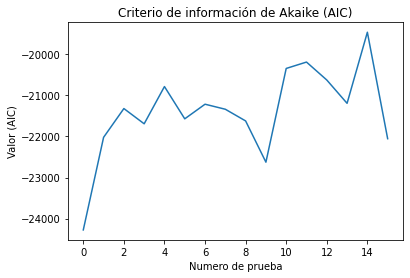

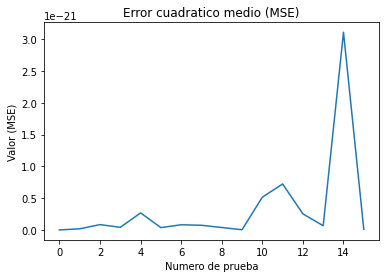

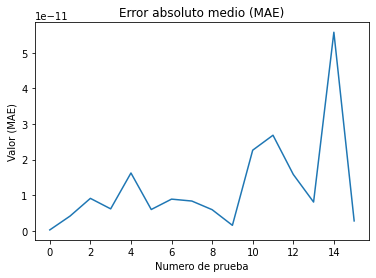

Minimo del Criterio Akaike:  -24275.436984326665
Parametros: P=  0 D =  0 Q =  0 Desfase =  15
************************* y_l *******************
[607    44.0
608    45.0
609    36.0
610    51.0
611    50.0
612    37.0
613    47.0
614    47.0
615    42.0
616    61.0
617    29.0
618    14.0
619     4.0
620     2.0
621     1.0
Name: ALL_CASES, dtype: float64, 445    44.0
446    45.0
447    36.0
448    51.0
449    50.0
450    37.0
451    47.0
452    47.0
453    42.0
454    61.0
455    29.0
456    14.0
457     4.0
458     2.0
459     1.0
dtype: float64]


D:\ProgramData\Anaconda3\envs\tf2\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
D:\ProgramData\Anaconda3\envs\tf2\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


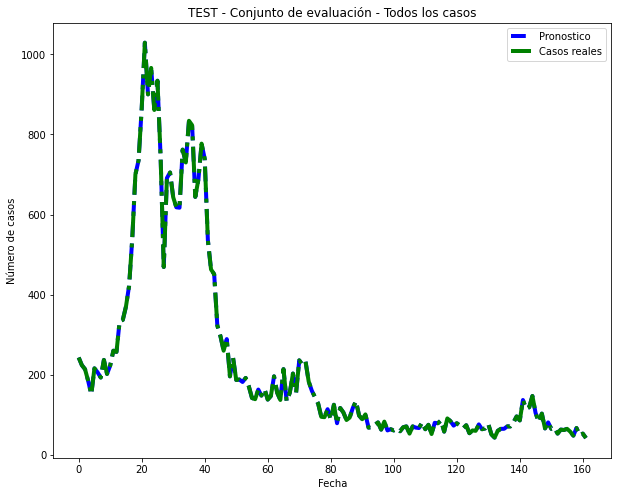

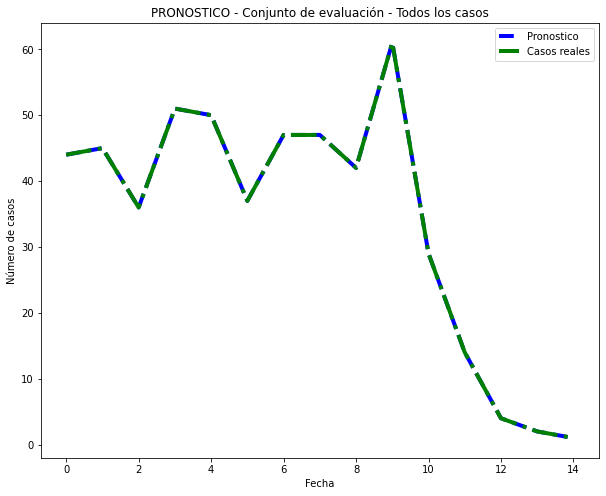

Minimo Error Cuadratico Medio:  8.215653253272412e-26
Parametros: P=  0 D =  0 Q =  0 Desfase =  0


D:\ProgramData\Anaconda3\envs\tf2\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
D:\ProgramData\Anaconda3\envs\tf2\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


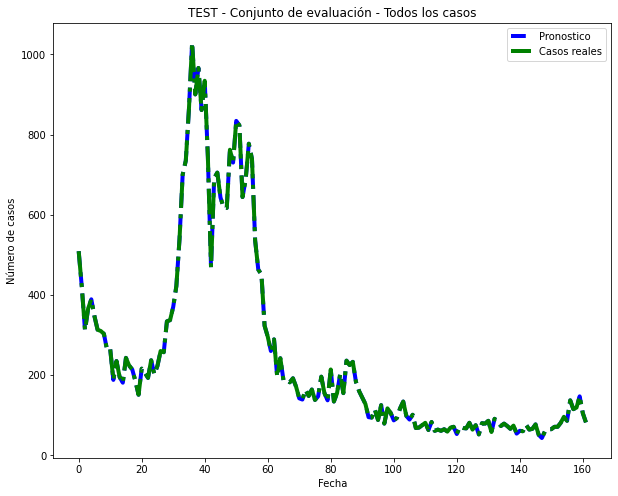

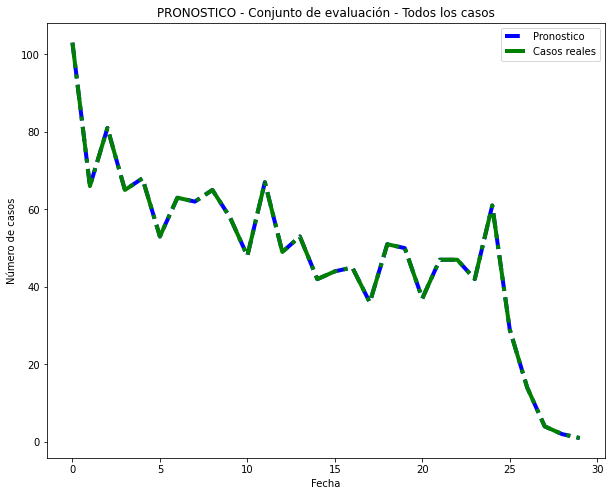

Minimo Error Absoluto:  2.8013805267282467e-13
Parametros: P=  0 D =  0 Q =  0 Desfase =  15


D:\ProgramData\Anaconda3\envs\tf2\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
D:\ProgramData\Anaconda3\envs\tf2\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


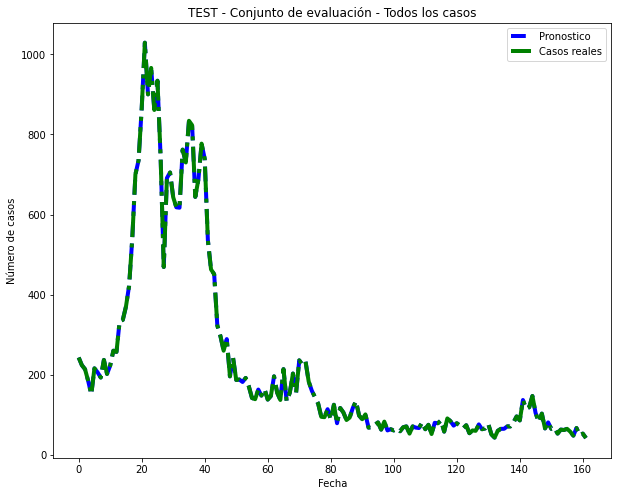

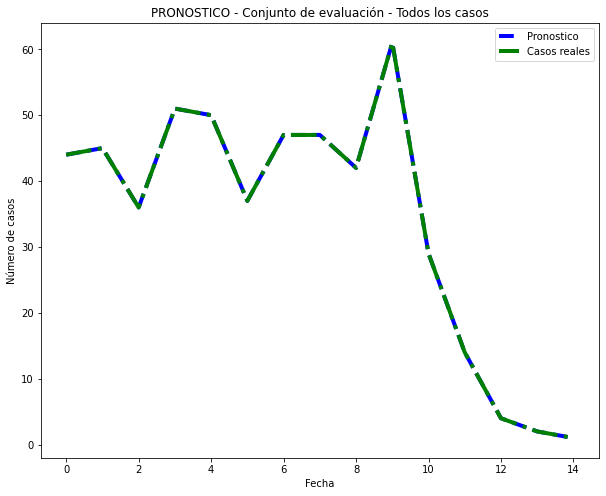



Parametros de Criterio Akaike minimo:  0 ARMA P = 0 x D = 0 x Q = 0, Desfase = 0, AIC = -24275.436984326665, MSE = 8.215653253272412e-26, MAE = 2.8013805267282467e-13

Parametros de RMSE minimo:  0 ARMA P = 0 x D = 0 x Q = 0, Desfase = 0, AIC = -24275.436984326665, MSE = 8.215653253272412e-26, MAE = 2.8013805267282467e-13

Parametros de RMSE minimo:  0 ARMA P = 0 x D = 0 x Q = 0, Desfase = 0, AIC = -24275.436984326665, MSE = 8.215653253272412e-26, MAE = 2.8013805267282467e-13






In [7]:
#Lectura de datos
FILE_D = 'D:/EN REVISION/PRUEBA TODOS/DATOS_SEMANALES/DATOS_SEMANALES_ESTACIONES_NINO_INTERPOLADOS.csv'


# # 122 Para seleccionar hasta 2016-12-31
# # 134 Para seleccionar hasta 2017-12-31
# hasta_2016 = 122
# hasta_2017 = 445

# Limite = hasta_2017

n_desfase = 16
# evalua_modelo(FILE_D, n_desfase, 445, 607,  'Confirmado', 2)
evalua_modelo(FILE_D, n_desfase, 445, 607, 'Todos', 1)

In [8]:
#Datos mensuales estandarizados

In [9]:
# #Lectura de datos
# FILE_D = 'DATOS_MENSUALES/DATOS_MENSUALES_NORMALIZADOS_CALI.csv'

# # 122 Para seleccionar hasta 2016-12-31
# # 134 Para seleccionar hasta 2017-12-31
# hasta_2016 = 122
# hasta_2017 = 134

# Limite = hasta_2017

# n_desfase = 4
# evalua_modelo(FILE_D, n_desfase, hasta_2017, 'Confirmado', 2)
# evalua_modelo(FILE_D, n_desfase, hasta_2017, 'Todos', 2)


In [10]:
#Datos semanales

In [11]:
# #Lectura de datos
# FILE_D = 'DATOS_SEMANALES/DATOS_SEMANALES_ESTACIONES_NINO_INTERPOLADOS.csv'


# # 528 Para seleccionar hasta 2016-12-31
# # 580 Para seleccionar hasta 2017-12-31
# hasta_2016 = 528
# hasta_2017 = 580


# Limite = hasta_2017

# n_desfase = 4
# evalua_modelo(FILE_D, n_desfase, hasta_2017, 'Confirmado', 2)
# evalua_modelo(FILE_D, n_desfase, hasta_2017, 'Todos', 2)



In [12]:
#Datos diarios interpolando NAN

In [13]:
# FILE_D = 'DATOS_DIARIOS/DATOS_DIARIOS_ESTACIONES_NINO_INTERPOLADOS.csv'


# # 3611 Para seleccionar hasta 2016-12-31
# # 3970 Para seleccionar hasta 2017-12-31
# hasta_2016 = 3611
# hasta_2017 = 3970

# Limite = hasta_2017


# n_desfase = 4
# evalua_modelo(FILE_D, n_desfase, hasta_2017, 'Confirmado', 2)
# evalua_modelo(FILE_D, n_desfase, hasta_2017, 'Todos', 2)



In [14]:
#Datos diarios eliminando NAN

In [15]:
# FILE_D = 'DATOS_DIARIOS/DATOS_DIARIOS_ESTACIONES_NINO.csv'


# # 3611 Para seleccionar hasta 2016-12-31
# # 3970 Para seleccionar hasta 2017-12-31
# hasta_2016 = 3611
# hasta_2017 = 3970

# Limite = hasta_2017


# n_desfase = 4
# evalua_modelo(FILE_D, n_desfase, hasta_2017, 'Confirmado', 2)
# evalua_modelo(FILE_D, n_desfase, hasta_2017, 'Todos', 2)





In [16]:
FILE = 'D:/EN REVISION/PRUEBA TODOS/DATOS_SEMANALES/DATOS_SEMANALES_ESTACIONES_NINO_INTERPOLADOS.csv'
import pandas as pd
df = pd.read_csv(FILE)
df = df.dropna()
df

,YEAR,WEEK,PTPM_CON,HRA2_AUT_60_MEAN,HRA2_AUT_60_AMAX,HRA2_AUT_60_AMIN,TA2_AUT_60_MEAN,TA2_AUT_60_AMAX,TA2_AUT_60_AMIN,NINO1+2,...,NINO3,ANOM.1,NINO4,ANOM.2,NINO3.4,ANOM.3,ONI_ASCII,MEI,CONFIRMED_CASES,ALL_CASES
0,2006,47,27.2,72.210598,97.0,49.0,24.994293,31.1,20.0,22.690000,...,26.070000,1.090000,29.630000,1.000000,27.730000,1.080000,0.900000,0.900000,7.0,11.0
1,2006,48,11.2,72.344979,93.0,47.0,24.803634,31.4,20.2,23.015714,...,26.194286,1.145714,29.561429,0.991429,27.742857,1.127143,0.921429,0.767143,12.0,19.0
2,2006,49,26.1,81.267857,98.0,51.0,23.802560,30.7,19.5,23.450000,...,26.360000,1.220000,29.470000,0.980000,27.760000,1.190000,0.950000,0.590000,5.0,17.0
3,2006,50,47.4,74.266129,98.0,50.0,24.527267,31.1,18.9,23.450000,...,26.360000,1.220000,29.470000,0.980000,27.760000,1.190000,0.950000,0.590000,10.0,23.0
4,2006,51,39.0,76.517857,98.0,50.0,24.237500,31.1,19.7,23.450000,...,26.360000,1.220000,29.470000,0.980000,27.760000,1.190000,0.950000,0.590000,5.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
632,2019,1,1.6,66.011905,92.0,36.0,26.129762,34.5,18.5,24.885714,...,26.162857,0.602857,29.074286,0.747143,27.144286,0.574286,0.801429,0.087143,4.0,29.0
633,2019,2,21.9,74.708333,96.0,48.0,23.673810,30.5,19.6,25.100000,...,26.170000,0.540000,29.000000,0.700000,27.080000,0.510000,0.800000,0.080000,4.0,14.0
634,2019,3,11.8,71.714286,96.0,47.0,25.099405,32.8,19.5,25.100000,...,26.170000,0.540000,29.000000,0.700000,27.080000,0.510000,0.800000,0.080000,1.0,4.0
635,2019,4,0.0,67.488095,93.0,44.0,26.537500,33.6,20.0,25.100000,...,26.170000,0.540000,29.000000,0.700000,27.080000,0.510000,0.800000,0.080000,1.0,2.0


In [17]:
exog_x1 = df[['PTPM_CON', 'TA2_AUT_60_MEAN', 'TA2_AUT_60_AMAX', 'HRA2_AUT_60_MEAN', 'HRA2_AUT_60_AMAX', 'NINO3', 'NINO4', 'NINO3.4','CONFIRMED_CASES', 'ALL_CASES']]
exog_x1

,PTPM_CON,TA2_AUT_60_MEAN,TA2_AUT_60_AMAX,HRA2_AUT_60_MEAN,HRA2_AUT_60_AMAX,NINO3,NINO4,NINO3.4,CONFIRMED_CASES,ALL_CASES
0,27.2,24.994293,31.1,72.210598,97.0,26.070000,29.630000,27.730000,7.0,11.0
1,11.2,24.803634,31.4,72.344979,93.0,26.194286,29.561429,27.742857,12.0,19.0
2,26.1,23.802560,30.7,81.267857,98.0,26.360000,29.470000,27.760000,5.0,17.0
3,47.4,24.527267,31.1,74.266129,98.0,26.360000,29.470000,27.760000,10.0,23.0
4,39.0,24.237500,31.1,76.517857,98.0,26.360000,29.470000,27.760000,5.0,12.0
...,...,...,...,...,...,...,...,...,...,...
632,1.6,26.129762,34.5,66.011905,92.0,26.162857,29.074286,27.144286,4.0,29.0
633,21.9,23.673810,30.5,74.708333,96.0,26.170000,29.000000,27.080000,4.0,14.0
634,11.8,25.099405,32.8,71.714286,96.0,26.170000,29.000000,27.080000,1.0,4.0
635,0.0,26.537500,33.6,67.488095,93.0,26.170000,29.000000,27.080000,1.0,2.0


In [18]:
FILE = 'D:/EN REVISION/PRUEBA TODOS/DATOS_SEMANALES/DATOS_SEMANALES_ESTACIONES_NINO_INTERPOLADOS.csv'
import pandas as pd
df = pd.read_csv(FILE)
df = df.dropna()
df



exog_x1 = df[['PTPM_CON', 'TA2_AUT_60_MEAN', 'TA2_AUT_60_AMAX', 'HRA2_AUT_60_MEAN', 'HRA2_AUT_60_AMAX', 'NINO3', 'NINO4', 'NINO3.4','CONFIRMED_CASES', 'ALL_CASES']]

exog_x1 = pd.DataFrame(exog_x1);
exog_x1
exog_x = desfasar(exog_x1, 0, 3);
# # endog_y = df[Columna].shift(-3).dropna();
# # exog_x
